# Create a baseline model

In [1]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Create the model

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=12,  # test nearby depths
    max_iter=1500,
    min_samples_leaf=8,  # test smaller and larger values
    n_iter_no_change=22,
    random_state=42,
)
lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_model = KNeighborsRegressor(n_neighbors=5)

xgb_base_model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42,
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

14:27:43 - Start training
14:27:43 - Calculate performance for hgb
14:27:43 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
14:27:43 - Split 1 - Model: hgb
14:27:43 - Fitting the model
14:29:03 - Predicting
14:29:03 - Calculating scores
14:29:03 - R^2: 0.6805388410070611, RMSE: 1.8525363172723457, MAE: 1.376841286835177, MSE: 3.4318908068129854
14:29:03 - Split 2 - Model: hgb
14:29:03 - Fitting the model
14:30:43 - Predicting
14:30:44 - Calculating scores
14:30:44 - R^2: 0.6780900920280373, RMSE: 1.862613462654542, MAE: 1.390072738359794, MSE: 3.4693289112619436
14:30:44 - Split 3 - Model: hgb
14:30:44 - Fitting the model
14:32:46 - Predicting
14:32:47 - Calculating scores
14:32:47 - R^2: 0.6778425260802076, RMSE: 1.8444791330085342, MAE: 1.3791881042198273, MSE: 3.4021032721039135
14:32:47 - Split 4 - Model: hgb
14:32:47 - Fitting the model
14:34:38 - Predicting
14:34:39 - Calculating scores
14:34:39 - R^2: 0.6753716708438111, RMSE: 1.873

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


14:43:16 - Predicting
14:43:26 - Calculating scores
14:43:26 - R^2: 0.6881604858482039, RMSE: 1.8303041810123595, MAE: 1.3461724134153108, MSE: 3.3500133950313242
14:43:26 - Split 2 - Model: stacking_regressor
14:43:26 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


14:47:51 - Predicting
14:48:01 - Calculating scores
14:48:01 - R^2: 0.6838507944278771, RMSE: 1.8458721319678433, MAE: 1.3628618197900007, MSE: 3.4072439275755113
14:48:01 - Split 3 - Model: stacking_regressor
14:48:01 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


14:52:11 - Predicting
14:52:21 - Calculating scores
14:52:21 - R^2: 0.6856705079054894, RMSE: 1.8219321775934971, MAE: 1.3456737801958205, MSE: 3.3194368597505823
14:52:21 - Split 4 - Model: stacking_regressor
14:52:21 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


14:57:26 - Predicting
14:57:38 - Calculating scores
14:57:38 - R^2: 0.6827268022279644, RMSE: 1.8517918779036788, MAE: 1.3672280279787181, MSE: 3.4291331590700334
14:57:38 - Split 5 - Model: stacking_regressor
14:57:38 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


15:01:58 - Predicting
15:02:08 - Calculating scores
15:02:08 - R^2: 0.6787698434773626, RMSE: 1.8397089061635703, MAE: 1.3577840102088103, MSE: 3.3845288594175607
15:02:08 - Training finished
Final estimator RMSE: 1.8379218549281897
Final estimator R2: 0.6838356867773795
Final estimator MSE: 3.3780712401690023
Final estimator MAE: 1.355944010317732


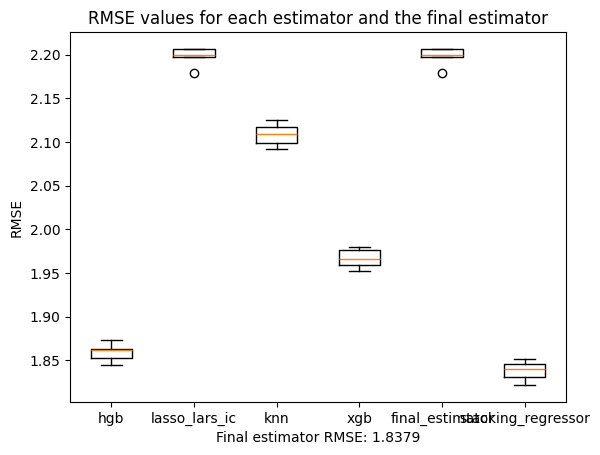

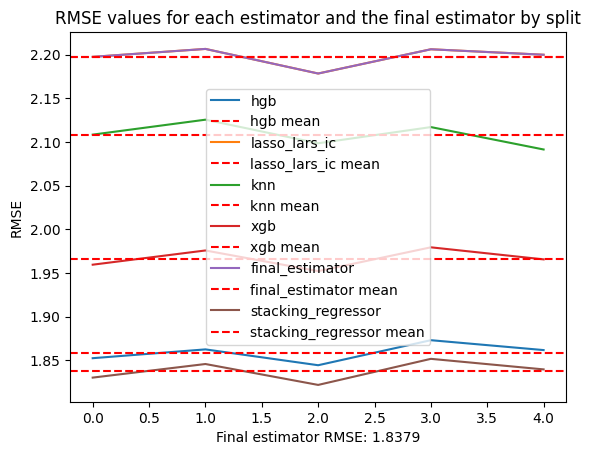

In [7]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-stacking-tuned-LLIC-HGB'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

## Predict test data

In [8]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))
X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    y_pred = y_pred.apply(lambda x: bg_min_train if x < 0 else x)

test_data['bg+1:00'] = y_pred
test_data.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.048927
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.708816
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.894400
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.047225
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.752507


In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,9.048927
p01_8460,5.708816
p01_8461,7.894400
p01_8462,11.047225
p01_8463,6.752507
...,...
p24_256,6.136689
p24_257,10.194559
p24_258,6.440628


In [11]:
submission.to_csv(f'submission-{model_name}.csv')